# 0. Imports and Load Data

In [2]:
from google.colab import drive
import os

# 1. Montar todo Google Drive
drive.mount('/content/drive')

# 2. Definir la ruta de la carpeta específica dentro de Drive
# Reemplaza 'MiCarpetaProyecto' por el nombre real de tu carpeta.
folder_name = 'Challenge_ML_Computer_Vision'
folder_path = f'/content/drive/MyDrive/{folder_name}'

# 3. Verificar si la carpeta existe y cambiar el directorio de trabajo
if os.path.exists(folder_path):
    os.chdir(folder_path)
    print(f"Directorio de trabajo cambiado a: {os.getcwd()}")
else:
    print(f"Error: La carpeta '{folder_name}' no existe en MyDrive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directorio de trabajo cambiado a: /content/drive/MyDrive/Challenge_ML_Computer_Vision


In [3]:
pwd

'/content/drive/MyDrive/Challenge_ML_Computer_Vision'

In [45]:
!unzip data.zip -d .

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ./data/train/labels/40RYVAAKAGDC_jpg.rf.14f2ec2660957b3949b6bcf81d5a7b93.txt  
  inflating: ./__MACOSX/data/train/labels/._40RYVAAKAGDC_jpg.rf.14f2ec2660957b3949b6bcf81d5a7b93.txt  
  inflating: ./data/train/labels/8V8WE7VA4WKF_jpg.rf.c77d9976ad608e3937d0455607468644.txt  
  inflating: ./__MACOSX/data/train/labels/._8V8WE7VA4WKF_jpg.rf.c77d9976ad608e3937d0455607468644.txt  
  inflating: ./data/train/labels/YU3YJ0B38J4N_jpg.rf.44b4504f5c02482282ba5d3ba8da4ca9.txt  
  inflating: ./__MACOSX/data/train/labels/._YU3YJ0B38J4N_jpg.rf.44b4504f5c02482282ba5d3ba8da4ca9.txt  
  inflating: ./data/train/labels/BU60MB3COOTI_jpg.rf.c9e1896b4d6ba4ee49dbf335631611d6.txt  
  inflating: ./__MACOSX/data/train/labels/._BU60MB3COOTI_jpg.rf.c9e1896b4d6ba4ee49dbf335631611d6.txt  
  inflating: ./data/train/labels/Forklift_211_jpg.rf.8c9d534cb931702f996632f862fe14ce.txt  
  inflating: ./__MACOSX/data/train/labels/._Forklift_211_jpg.

In [6]:
!ls data/train/labels | head -n 5

0001487_jpg.rf.dc03429f7a9c49f0509457442a3505b7.txt
0001657_jpg.rf.d0f802bfb167382c873a2a230ec418cf.txt
0001687_jpg.rf.1bc6ee854607000a7ca382f221f92a53.txt
0001687_jpg.rf.233f2a283f5282763c49e54d7cdd78e0.txt
0001687_jpg.rf.2aacf6d28e3653e9ddf0cddd3aea577e.txt


In [5]:
# Lista los primeros 5 archivos en la carpeta de imágenes de entrenamiento
!echo "Verificando las imágenes de entrenamiento..."
!ls data/train/images | head -n 5

# Verifica también la cantidad total de archivos para confirmar que el dataset es completo
!echo "\nConteo total de archivos de imagen en train (debería ser > 20,000):"
!ls data/train/images | wc -l

Verificando las imágenes de entrenamiento...
0001487_jpg.rf.6a9c741100b3ee95d423218cddc00857.jpg
0001487_jpg.rf.dc03429f7a9c49f0509457442a3505b7.jpg
0001487_jpg.rf.e3471020a2c94b574636bacc2e47208b.jpg
0001657_jpg.rf.6f984216226d012cdb72c08f4b77bd3f.jpg
0001657_jpg.rf.72a253ccb8103c626b1903c0bda12c70.jpg
\nConteo total de archivos de imagen en train (debería ser > 20,000):
19682


In [5]:
!pip install -r requirements.txt

In [4]:
import os
import glob
import random
import json
from pathlib import Path
import pandas as pd
import yaml
import cv2
import matplotlib.pyplot as plt
from collections import Counter
from ultralytics import YOLO
import warnings

warnings.filterwarnings('ignore')

In [6]:
DATA_YAML_PATH = "data/data.yaml"

assert os.path.exists(DATA_YAML_PATH), f"data.yaml not found in {DATA_YAML_PATH}"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

data_cfg

{'train': 'train/images',
 'val': 'valid/images',
 'test': 'test/images',
 'nc': 17,
 'names': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'roboflow': {'workspace': 'srafil-ar',
  'project': 'forklift-6ms6v',
  'version': 1,
  'license': 'CC BY 4.0',
  'url': 'https://universe.roboflow.com/srafil-ar/forklift-6ms6v/dataset/1'}}

In [7]:
PROJECT_ROOT = os.getcwd() # Debería ser /content/Challenge_ML_Computer_Vision
train_dir = os.path.join(PROJECT_ROOT, "data", data_cfg['train'])
val_dir   = os.path.join(PROJECT_ROOT, "data", data_cfg['val'])
test_dir  = os.path.join(PROJECT_ROOT, "data", data_cfg['test'])
class_names = data_cfg.get("names", [])
nc = int(data_cfg.get("nc", len(class_names)))

print("Train images dir:", train_dir)
print("Val images dir  :", val_dir)
print("Test images dir :", test_dir)
print("Classes (nc)     :", nc)
print("Classes name:", class_names)

Train images dir: /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/train/images
Val images dir  : /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/valid/images
Test images dir : /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/test/images
Classes (nc)     : 17
Classes name: ['car', 'cardboard box', 'forklift', 'freight container', 'gloves', 'helmet', 'ladder', 'license plate', 'person', 'qr code', 'road sign', 'safety vest', 'traffic cone', 'traffic light', 'truck', 'van', 'wood pallet']


In [11]:
# 1. Listar el contenido del directorio de trabajo actual
print("Contenido del directorio actual:")
!ls

# 2. Listar el contenido de la carpeta 'data'
print("\nContenido de la carpeta 'data':")
!ls data/

# 3. Verificar si existen las carpetas de imágenes
print("\nVerificando subcarpetas de imágenes:")
!ls data/train/images | head -n 5

Contenido del directorio actual:
challenge  Dockerfile  Makefile		      requirements.txt	workflows
data	   docs        README.md	      runs
data.zip   __MACOSX    requirements-test.txt  tests

Contenido de la carpeta 'data':
data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid

Verificando subcarpetas de imágenes:
0001487_jpg.rf.6a9c741100b3ee95d423218cddc00857.jpg
0001487_jpg.rf.dc03429f7a9c49f0509457442a3505b7.jpg
0001487_jpg.rf.e3471020a2c94b574636bacc2e47208b.jpg
0001657_jpg.rf.6f984216226d012cdb72c08f4b77bd3f.jpg
0001657_jpg.rf.72a253ccb8103c626b1903c0bda12c70.jpg


In [75]:
import os
import yaml

# Cargar el data.yaml con la nueva ruta
DATA_YAML_PATH = "data/data.yaml"

with open(DATA_YAML_PATH, "r") as f:
    data_cfg = yaml.safe_load(f)

# Imprimir las rutas completas que YOLO usará
base_path = data_cfg.get("path")
train_path = os.path.join(base_path, data_cfg.get("train"))

print("Ruta de entrenamiento completa esperada:")
print(train_path)

# Verificar si existen imágenes en esa ruta
print("\nVerificación de imágenes:")
!ls {train_path} | head -n 5

# Si esto funciona, tu notebook encontrará las imágenes.

Ruta de entrenamiento completa esperada:
./data/train/images

Verificación de imágenes:
0001487_jpg.rf.6a9c741100b3ee95d423218cddc00857.jpg
0001487_jpg.rf.dc03429f7a9c49f0509457442a3505b7.jpg
0001487_jpg.rf.e3471020a2c94b574636bacc2e47208b.jpg
0001657_jpg.rf.6f984216226d012cdb72c08f4b77bd3f.jpg
0001657_jpg.rf.72a253ccb8103c626b1903c0bda12c70.jpg


In [76]:
pwd

'/content/drive/MyDrive/Challenge_ML_Computer_Vision'

In [77]:
import os

# Construye la ruta a la carpeta de etiquetas de entrenamiento
labels_path = "./data/train/labels"

print(f"Ruta de etiquetas esperada: {labels_path}")
print("Contenido de la carpeta 'labels':")
!ls {labels_path} | head -n 5

Ruta de etiquetas esperada: ./data/train/labels
Contenido de la carpeta 'labels':
0001487_jpg.rf.6a9c741100b3ee95d423218cddc00857.txt
0001487_jpg.rf.dc03429f7a9c49f0509457442a3505b7.txt
0001487_jpg.rf.e3471020a2c94b574636bacc2e47208b.txt
0001657_jpg.rf.6f984216226d012cdb72c08f4b77bd3f.txt
0001657_jpg.rf.72a253ccb8103c626b1903c0bda12c70.txt


In [78]:
# 1. Buscar archivos .txt en la carpeta 'train'
print("Buscando etiquetas en /data/train/...")
!ls data/train/*.txt | head -n 5

# 2. Buscar archivos .txt en la carpeta raíz de 'data'
print("\nBuscando etiquetas en /data/...")
!ls data/*.txt | head -n 5

Buscando etiquetas en /data/train/...
ls: cannot access 'data/train/*.txt': No such file or directory

Buscando etiquetas en /data/...
data/README.dataset.txt
data/README.roboflow.txt


# 1. Data Analysis: First Sight

In [90]:
def yolo_label_paths(img_dir: str) -> list:
    img_paths = []
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        img_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    label_paths = []
    for ip in img_paths:
        lp = ip.replace(os.sep + "images" + os.sep, os.sep + "labels" + os.sep)
        lp = os.path.splitext(lp)[0] + ".txt"
        label_paths.append((ip, lp))
    return label_paths

def read_yolo_labels(label_path: str):
    if not os.path.exists(label_path):
        return []
    rows = []
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(float(parts[0]))
                cx, cy, w, h = map(float, parts[1:5])
                rows.append((cls_id, cx, cy, w, h))
    return rows


In [91]:
def analyze_split(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    per_class = Counter()
    objs_per_image = []
    areas = []

    for _, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        objs_per_image.append(len(labels))
        for (cls_id, cx, cy, w, h) in labels:
            per_class[cls_id] += 1
            areas.append(w * h)

    df_classes = pd.DataFrame({
        "class_id": list(per_class.keys()),
        "count": list(per_class.values())
    })
    df_classes["class_name"] = df_classes["class_id"].apply(lambda i: class_names[i] if i < len(class_names) else str(i))

    df_objs = pd.DataFrame({"objects_per_image": objs_per_image})
    df_areas = pd.DataFrame({"bbox_area_norm": areas})

    return df_classes.sort_values("count", ascending=False), df_objs, df_areas

df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(    class_id  count         class_name
 0          2  24213           forklift
 1          8  20480             person
 4          1   1266      cardboard box
 9         12   1023       traffic cone
 10         3    447  freight container,
        objects_per_image
 count       20546.000000
 mean            2.405237
 std             2.472610
 min             1.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max            47.000000,
        bbox_area_norm
 count    49418.000000
 mean         0.155603
 std          0.224430
 min          0.000010
 25%          0.010547
 50%          0.045352
 75%          0.203203
 max          1.000000)

### How is the date distribuited?

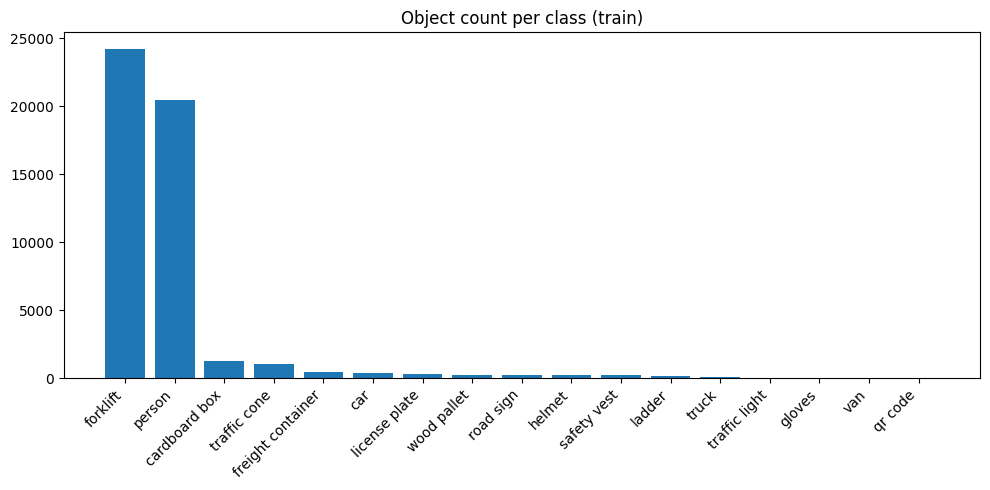

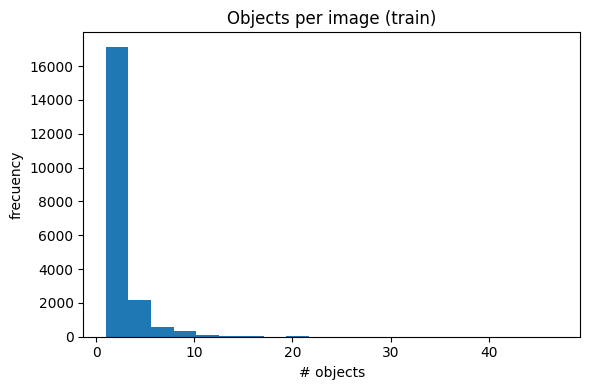

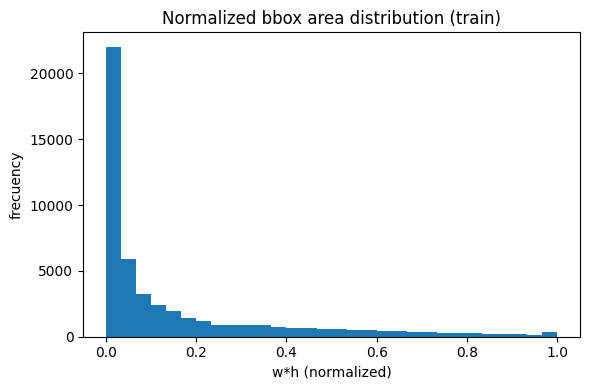

In [92]:
plt.figure(figsize=(10,5))
plt.bar(df_classes_train["class_name"], df_classes_train["count"])
plt.xticks(rotation=45, ha='right')
plt.title("Object count per class (train)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_objs_train["objects_per_image"], bins=20)
plt.title("Objects per image (train)")
plt.xlabel("# objects")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df_areas_train["bbox_area_norm"], bins=30)
plt.title("Normalized bbox area distribution (train)")
plt.xlabel("w*h (normalized)")
plt.ylabel("frecuency")
plt.tight_layout()
plt.show()

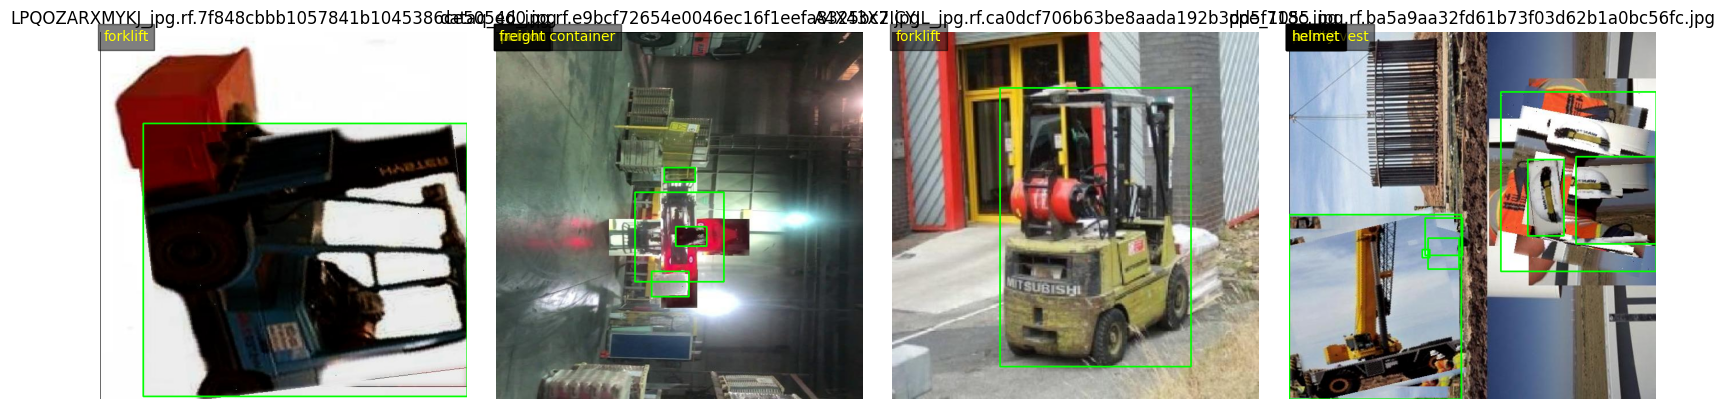

In [93]:
def draw_yolo_bbox(img, bbox, color=(0,255,0), thickness=2):
    H, W = img.shape[:2]
    cx, cy, bw, bh = bbox
    x1 = int((cx - bw/2) * W)
    y1 = int((cy - bh/2) * H)
    x2 = int((cx + bw/2) * W)
    y2 = int((cy + bh/2) * H)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
    return img

def visualize_samples(img_dir: str, class_names: list, n=4, seed=42):
    rng = random.Random(seed)
    pairs = yolo_label_paths(img_dir)
    sample = rng.sample(pairs, min(n, len(pairs)))
    fig, axes = plt.subplots(1, len(sample), figsize=(4*len(sample), 4))
    if len(sample) == 1:
        axes = [axes]
    for ax, (img_path, lbl_path) in zip(axes, sample):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)
        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))
            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, 15, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))
        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dir, class_names, n=4, seed=7)

### What methods would you use to verify the reliability of the labels?
# Para verficar la confiabilidad de las etiquetas de analaizará los outliers, para identificar los valores atipicos

In [94]:
# Emepezaremos con en análisis del area de las etiquetas

def find_iqr_outliers(df: pd.DataFrame, column: str, threshold: float = 1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)

    if lower_bound < 0:
        lower_bound = 0

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    print(f"--- Análisis IQR para {column} ---")
    print(f"Q1 (25%): {Q1:.6f}")
    print(f"Q3 (75%): {Q3:.6f}")
    print(f"IQR: {IQR:.6f}")
    print(f"Límite Inferior (Outliers pequeños): {lower_bound:.6f}")
    print(f"Límite Superior (Outliers grandes): {upper_bound:.6f}")
    print(f"\nTotal de Outliers detectados: {len(outliers)} ({len(outliers)/len(df) * 100:.2f}%)")

    return outliers, lower_bound, upper_bound

# Ejecutar el análisis en las áreas de las bounding boxes
outliers_area_train, lower_limit, upper_limit = find_iqr_outliers(
    df=df_areas_train,
    column='bbox_area_norm'
)

# Mostrar los outliers más grandes detectados
print("\nOutliers detectados por área (Top 5 más grandes):")
outliers_area_train.sort_values(by='bbox_area_norm', ascending=False).head()

--- Análisis IQR para bbox_area_norm ---
Q1 (25%): 0.010547
Q3 (75%): 0.203203
IQR: 0.192656
Límite Inferior (Outliers pequeños): 0.000000
Límite Superior (Outliers grandes): 0.492187

Total de Outliers detectados: 5239 (10.60%)

Outliers detectados por área (Top 5 más grandes):


bbox_area_norm
49249             1.0
480               1.0
18520             1.0
774               1.0
18398             1.0

In [95]:
# --- Función Modificada para Rastreo de Outliers ---
def analyze_split_with_paths(img_dir: str, class_names: list):
    pairs = yolo_label_paths(img_dir)
    data_list = []

    for img_path, lbl_path in pairs:
        labels = read_yolo_labels(lbl_path)
        for (cls_id, cx, cy, w, h) in labels:
            data_list.append({
                "class_id": cls_id,
                "bbox_area_norm": w * h,
                "image_path": img_path,
                "label_path": lbl_path
            })

    df_data = pd.DataFrame(data_list)
    return df_data

# Obtener todos los datos del set de entrenamiento con rutas
df_all_train_data = analyze_split_with_paths(train_dir, class_names)

# Identificar los Outliers con área 1.0 (los más críticos)
outliers_max_area = df_all_train_data[df_all_train_data['bbox_area_norm'] == 1.0]

print(f"Total de objetos con área 1.0 encontrados: {len(outliers_max_area)}")

Total de objetos con área 1.0 encontrados: 187


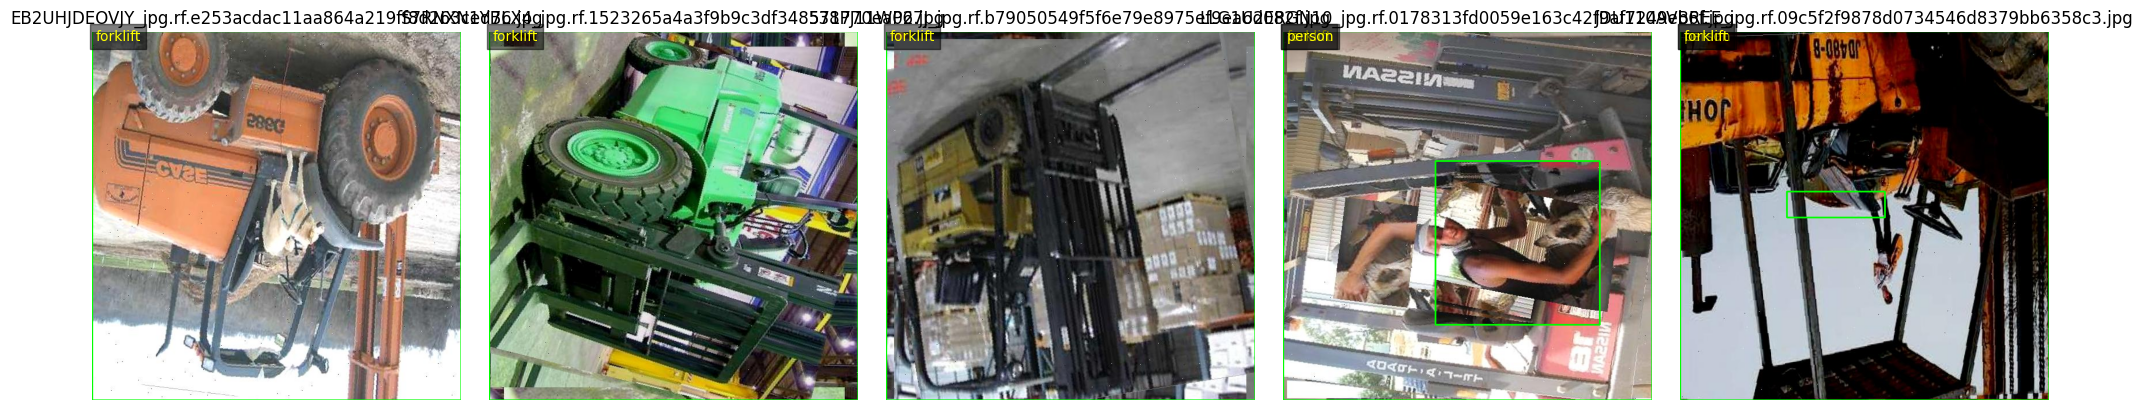

In [96]:
def visualize_specific_samples(image_paths: list, class_names: list):
    """Visualiza una lista específica de imágenes junto con sus etiquetas."""
    n = len(image_paths)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1:
        axes = [axes]

    for ax, img_path in zip(axes, image_paths):
        lbl_path = str(Path(img_path).parent.parent / 'labels' / (Path(img_path).stem + ".txt"))

        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        labels = read_yolo_labels(lbl_path)

        for (cls_id, cx, cy, w, h) in labels:
            img = draw_yolo_bbox(img, (cx, cy, w, h))

            name = class_names[cls_id] if cls_id < len(class_names) else str(cls_id)
            ax.text(5, 15, name, color='yellow', bbox=dict(facecolor='black', alpha=0.5))

        ax.imshow(img)
        ax.set_title(Path(img_path).name)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Obtener una lista de las rutas únicas de las imágenes con área 1.0
images_to_check = outliers_max_area['image_path'].unique().tolist()

# Visualizar la muestra
visualize_specific_samples(images_to_check[:5], class_names)

In [97]:
# Proceso de limpieza de etiquetas
import os
from pathlib import Path

# Obtener las rutas de los archivos de etiquetas
label_paths_to_clean = outliers_max_area['label_path'].unique().tolist()
count_removed_lines = 0

for lbl_path in label_paths_to_clean:
    lines_to_keep = []

    with open(lbl_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                # Calcula el área normalizada (w * h)
                w, h = float(parts[3]), float(parts[4])
                area = w * h

                # Criterio de Eliminación: Si el área es 1.0 o está muy cerca del máximo.
                if area >= 0.999:
                    count_removed_lines += 1
                    continue

            lines_to_keep.append(line)

    with open(lbl_path, 'w') as f:
        f.writelines(lines_to_keep)

print(f"\n✅ Proceso de limpieza finalizado. Se eliminaron {count_removed_lines} etiquetas con área 1.0.")


✅ Proceso de limpieza finalizado. Se eliminaron 187 etiquetas con área 1.0.


In [ ]:
# verificacion que se eliminaron las etiquetas con área = 1.0
df_all_train_data = analyze_split_with_paths(train_dir, class_names)
outliers_max_area = df_all_train_data[df_all_train_data['bbox_area_norm'] == 1.0]
print(f"Total de objetos con área 1.0 encontrados: {len(outliers_max_area)}")

Total de objetos con área 1.0 encontrados: 0


In [98]:
# Re-analizar las etiquetas con los archivos labels ya limpios
df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)

# Visualización rápida del nuevo conteo de clases y áreas (Opcional)
print("Nueva distribución de áreas (descriptiva):")
print(df_areas_train.describe())

Nueva distribución de áreas (descriptiva):
       bbox_area_norm
count    49231.000000
mean         0.152396
std          0.218727
min          0.000010
25%          0.010474
50%          0.044844
75%          0.199724
max          0.998437


In [99]:
# Re-ejecutar el análisis IQR
# Para comprobar que se mejoraron los parámetros
outliers_area_train_nuevo, lower_limit_nuevo, upper_limit_nuevo = find_iqr_outliers(
    df=df_areas_train,
    column='bbox_area_norm'
)

print("\n--- Outliers detectados (Conteo Total) ---")
print(f"Total de Outliers detectados: {len(outliers_area_train_nuevo)} ({len(outliers_area_train_nuevo)/len(df_areas_train) * 100:.2f}%)")

--- Análisis IQR para bbox_area_norm ---
Q1 (25%): 0.010474
Q3 (75%): 0.199724
IQR: 0.189250
Límite Inferior (Outliers pequeños): 0.000000
Límite Superior (Outliers grandes): 0.483600

Total de Outliers detectados: 5224 (10.61%)

--- Outliers detectados (Conteo Total) ---
Total de Outliers detectados: 5224 (10.61%)


In [100]:
# Ahora analizamos los outliners de la cantidad de etiquetas por imagen "objects_per_image"
def find_iqr_outliers_by_image_count(df: pd.DataFrame, column: str, threshold: float = 1.5):
    """Identifica outliers en una columna usando el método del Rango Intercuartílico (IQR)."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)

    # Nos enfocamos en outliers superiores (imágenes con demasiados objetos)
    outliers = df[df[column] > upper_bound]

    print(f"--- Análisis IQR para {column} ---")
    print(f"Q1 (25%): {Q1:.2f} objetos")
    print(f"Q3 (75%): {Q3:.2f} objetos")
    print(f"Límite Superior (Outliers densos): {upper_bound:.2f} objetos")
    print(f"\nTotal de imágenes Outliers detectadas: {len(outliers)} ({len(outliers)/len(df) * 100:.2f}%)")

    return outliers, upper_bound

df_objs_train_outliers, upper_limit_count = find_iqr_outliers_by_image_count(
    df=df_objs_train,
    column='objects_per_image'
)

--- Análisis IQR para objects_per_image ---
Q1 (25%): 1.00 objetos
Q3 (75%): 3.00 objetos
Límite Superior (Outliers densos): 6.00 objetos

Total de imágenes Outliers detectadas: 864 (4.21%)


In [101]:
#funcion para detectar las imagenes a eliminar
import shutil

train_pairs = yolo_label_paths(train_dir)

files_to_delete = []
deleted_count = 0

for img_path, lbl_path in train_pairs:
    labels = read_yolo_labels(lbl_path)
    count = len(labels)

    # Si la imagen supera el límite superior (6 objetos)
    if count > upper_limit_count:
        files_to_delete.append({
            'img': img_path,
            'lbl': lbl_path,
            'count': count
        })

print(f"Imágenes identificadas para eliminación (más de {upper_limit_count} objetos): {len(files_to_delete)}")

Imágenes identificadas para eliminación (más de 6.0 objetos): 864


In [102]:
#eliminacion de las imagenes detectadas con mas de 6 etiquetas
for file_info in files_to_delete:
    try:
        os.remove(file_info['img'])
        os.remove(file_info['lbl'])
        deleted_count += 1
    except OSError as e:
        print(f"Error al eliminar {file_info['img']}: {e}")

print(f"Se eliminaron {deleted_count} pares de imagen/etiqueta que excedían el límite de {upper_limit_count} objetos.")

Se eliminaron 864 pares de imagen/etiqueta que excedían el límite de 6.0 objetos.


In [103]:
df_classes_train, df_objs_train, df_areas_train = analyze_split(train_dir, class_names)
df_classes_train.head(), df_objs_train.describe(), df_areas_train.describe()

(   class_id  count     class_name
 0         2  22626       forklift
 1         8  15788         person
 3         7    231  license plate
 9         0    207            car
 4         1    177  cardboard box,
        objects_per_image
 count       19682.000000
 mean            2.021695
 std             1.221468
 min             0.000000
 25%             1.000000
 50%             2.000000
 75%             3.000000
 max             6.000000,
        bbox_area_norm
 count    39791.000000
 mean         0.179236
 std          0.231169
 min          0.000176
 25%          0.015936
 50%          0.068225
 75%          0.265999
 max          0.998437)

# 2. Training

In [8]:
# ==============================
# 🔧 HYPERPARAMETERS — EXPERIMENTAL SETUP
# ==============================

# TODO: Fill in the hyperparameters based on your dataset analysis.
# Justify your choices in the Markdown cell above.

EPOCHS = 40   #se aumentaron las epocas de 30 a 40 debido al desbalance en clases
IMGSZ  = 800  #resolucion de las imagenes
BATCH  = 64   #para mayor estabilidad del entramiento
DEVICE = "cuda"        # or "cuda" if available
SEED = 42

# Try YOLO11; if not available use YOLOv8
weights_try = ["yolo11n.pt", "yolov8n.pt"]
model = None
for w in weights_try:
    try:
        model = YOLO(w)
        print("Using:", w)
        break
    except Exception as e:
        print(f"Failed to load {w}: {e}")

assert model is not None, "Could not load a base model (yolo11n.pt / yolov8n.pt). Install ultralytics and make sure you have an active internet connection to download the weights."

Using: yolo11n.pt


In [107]:
import os
PROJECT_ROOT = os.getcwd() # Esto debe ser /content/Challenge_ML_Computer_Vision
DATA_PATH = os.path.join(PROJECT_ROOT, "data") # Esto debe ser /content/Challenge_ML_Computer_Vision/data
print(DATA_PATH)

/content/drive/MyDrive/Challenge_ML_Computer_Vision/data


In [9]:
pwd

'/content/drive/MyDrive/Challenge_ML_Computer_Vision'

In [112]:
# ==============================
# 🚀 TRAINING — BASELINE EXPERIMENT
# ==============================
# The results object contains metrics, charts, and run directory info.
# Feel free to adjust and rerun with different hyperparameters.

results = model.train(data=DATA_YAML_PATH, epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH, device=DEVICE , patience=15)
results

New https://pypi.org/project/ultralytics/8.3.231 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.74 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data/data.yaml, epochs=40, time=None, patience=15, batch=64, imgsz=800, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

100%|██████████| 755k/755k [00:00<00:00, 118MB/s]


Overriding model.yaml nc=80 with nc=17

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/train/labels... 19682 images, 64 backgrounds, 0 corrupt: 100%|██████████| 19682/19682 [03:35<00:00, 91.22it/s] 


train: New cache created: /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/valid/labels... 1967 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1967/1967 [00:21<00:00, 89.49it/s] 


val: New cache created: /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/valid/labels.cache
Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to runs/detect/train13
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      15.2G       1.18      2.883      1.508        141        800: 100%|██████████| 308/308 [02:26<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


                   all       1967       4615       0.96     0.0676     0.0743     0.0384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      15.2G     0.9763      1.781      1.361        111        800: 100%|██████████| 308/308 [02:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.80it/s]

                   all       1967       4615      0.907     0.0241     0.0185    0.00639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      15.2G      1.041       1.64      1.418        139        800: 100%|██████████| 308/308 [02:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


                   all       1967       4615      0.214     0.0203      0.013    0.00504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      15.2G      1.064      1.462      1.444        124        800: 100%|██████████| 308/308 [02:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]

                   all       1967       4615      0.324      0.058     0.0624     0.0319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      15.2G     0.9739      1.258      1.371        112        800: 100%|██████████| 308/308 [02:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]


                   all       1967       4615      0.623     0.0552     0.0526     0.0258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      15.1G     0.9186      1.168      1.333        169        800: 100%|██████████| 308/308 [02:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.78it/s]

                   all       1967       4615      0.697     0.0588      0.067     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      15.1G      0.875      1.093      1.299        111        800: 100%|██████████| 308/308 [02:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]

                   all       1967       4615      0.646      0.072     0.0816     0.0443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      15.2G     0.8536       1.05      1.282        121        800: 100%|██████████| 308/308 [02:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.714     0.0787      0.101     0.0585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      15.3G     0.8248      1.014       1.26        133        800: 100%|██████████| 308/308 [02:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all       1967       4615      0.841     0.0736     0.0954     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      15.2G     0.8079     0.9854      1.246        135        800: 100%|██████████| 308/308 [02:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.749      0.117      0.108     0.0643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      15.2G     0.7909     0.9551      1.233        123        800: 100%|██████████| 308/308 [02:04<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all       1967       4615      0.692      0.144      0.122     0.0717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      15.2G     0.7749     0.9299       1.22        137        800: 100%|██████████| 308/308 [02:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all       1967       4615      0.798      0.122      0.125      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      15.2G     0.7711     0.9174      1.217        126        800: 100%|██████████| 308/308 [02:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.869      0.107      0.127     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      15.2G     0.7493     0.8975      1.203        128        800: 100%|██████████| 308/308 [02:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all       1967       4615      0.776      0.136      0.128     0.0802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      15.2G     0.7459     0.8754      1.199        125        800: 100%|██████████| 308/308 [02:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all       1967       4615      0.857      0.117      0.124      0.077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      15.2G     0.7351     0.8662       1.19        156        800: 100%|██████████| 308/308 [02:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all       1967       4615      0.737      0.129      0.132     0.0832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      15.2G     0.7239     0.8465      1.181        108        800: 100%|██████████| 308/308 [02:04<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.691      0.151      0.129     0.0746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      15.1G     0.7136     0.8371      1.174        124        800: 100%|██████████| 308/308 [02:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all       1967       4615      0.769      0.135      0.144      0.089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      15.2G     0.7039     0.8177      1.168        136        800: 100%|██████████| 308/308 [02:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]

                   all       1967       4615       0.76      0.146      0.153     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      15.2G     0.7031     0.8113      1.166        137        800: 100%|██████████| 308/308 [02:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all       1967       4615      0.823      0.144      0.143     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      15.2G     0.6932     0.7972      1.159        130        800: 100%|██████████| 308/308 [02:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]

                   all       1967       4615      0.882      0.149      0.161      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      15.1G     0.6807     0.7836      1.152        159        800: 100%|██████████| 308/308 [02:03<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

                   all       1967       4615       0.84      0.146      0.155     0.0982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      15.3G      0.679     0.7771      1.151        108        800: 100%|██████████| 308/308 [02:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

                   all       1967       4615      0.883      0.173      0.169      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      15.2G      0.673     0.7625      1.143        120        800: 100%|██████████| 308/308 [02:04<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]

                   all       1967       4615      0.901      0.153      0.162      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      15.2G     0.6662     0.7588      1.139        136        800: 100%|██████████| 308/308 [02:03<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all       1967       4615      0.816      0.177      0.172      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      15.2G     0.6574     0.7411      1.131        145        800: 100%|██████████| 308/308 [01:59<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]

                   all       1967       4615      0.822      0.158      0.165      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      15.3G     0.6529     0.7288      1.129        147        800: 100%|██████████| 308/308 [01:58<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.72it/s]

                   all       1967       4615      0.834      0.157      0.163      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      15.2G     0.6475     0.7262      1.122        116        800: 100%|██████████| 308/308 [01:58<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.736      0.166      0.168      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      15.2G     0.6396     0.7207      1.119        114        800: 100%|██████████| 308/308 [01:59<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all       1967       4615      0.799      0.163      0.176      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      15.2G     0.6335     0.7043      1.117        119        800: 100%|██████████| 308/308 [01:59<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]

                   all       1967       4615      0.697      0.192      0.175      0.118


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40        15G     0.6715     0.6941      1.145         54        800: 100%|██████████| 308/308 [01:59<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.78it/s]

                   all       1967       4615       0.83      0.178      0.182      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40        15G     0.6563     0.6678      1.129         80        800: 100%|██████████| 308/308 [01:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]

                   all       1967       4615      0.746      0.188      0.175      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      15.1G     0.6469     0.6528      1.124         57        800: 100%|██████████| 308/308 [01:52<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]

                   all       1967       4615      0.658      0.201      0.179      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      15.1G     0.6362     0.6395      1.115         70        800: 100%|██████████| 308/308 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all       1967       4615      0.697      0.194      0.181      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      15.1G     0.6258     0.6251      1.107         72        800: 100%|██████████| 308/308 [01:51<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.75it/s]

                   all       1967       4615      0.703      0.186      0.183      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      15.1G     0.6189     0.6119        1.1         70        800: 100%|██████████| 308/308 [01:51<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.764      0.184      0.191      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      15.1G       0.61     0.5979      1.095         66        800: 100%|██████████| 308/308 [01:51<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.768      0.178      0.192      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      15.1G        0.6     0.5849      1.085         65        800: 100%|██████████| 308/308 [01:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.78it/s]

                   all       1967       4615      0.794      0.177      0.194      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40        15G     0.5954     0.5757      1.082         64        800: 100%|██████████| 308/308 [01:52<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:09<00:00,  1.76it/s]

                   all       1967       4615      0.728       0.18       0.19      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      15.1G     0.5876     0.5668      1.079         64        800: 100%|██████████| 308/308 [01:52<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]

                   all       1967       4615      0.652      0.217      0.192       0.13



40 epochs completed in 1.466 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 5.5MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics 8.3.74 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO11n summary (fused): 238 layers, 2,585,467 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.44it/s]


                   all       1967       4615      0.659      0.218      0.192       0.13
                   car         14         31       0.31      0.516      0.377      0.223
         cardboard box         18         64      0.418     0.0781     0.0812      0.047
              forklift       1967       2310      0.752      0.944      0.948      0.728
     freight container         13         23          0          0     0.0226    0.00897
                gloves          4          6          1          0          0          0
                helmet         15         22          1          0     0.0314     0.0161
                ladder         19         23      0.204       0.13      0.122     0.0823
         license plate         21         23      0.312     0.0615     0.0838      0.055
                person       1029       1938      0.543      0.825      0.765      0.456
             road sign         16         19          1          0    0.00292    0.00205
           safety ves

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79bf8776b710>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044

### ✏️ Discussion

Explain:
1. Why did you choose these hyperparameters?  
2. How do they affect training time, GPU/CPU usage, and accuracy?  
3. What would you try differently if you had more time or resources?

# 3. Evaluation


> 👉 **Task:** Evaluate your trained model using the validation set defined in `data.yaml`.

Run the following cell to compute key performance metrics
Then, summarize your results and provide your interpretation.

**Guidelines for your analysis:**
- **Quantitative metrics**
- **Error analysis**
- **Next steps**

In [113]:
# Cargar el modelo que rindió mejor (best.pt)
BEST_MODEL_PATH = 'runs/detect/train13/weights/best.pt'
model_to_evaluate = YOLO(BEST_MODEL_PATH)

print(f"Modelo cargado para evaluación desde: {BEST_MODEL_PATH}")

Modelo cargado para evaluación desde: runs/detect/train13/weights/best.pt


In [114]:
# Put Here your model metrics
# TODO:
# - Run model validation on the dataset below.
# - Capture metrics and save a summary to artifacts/metrics_summary.json.
# - Optionally, add visual analysis (PR curves, confusion matrix).

# Put your model evaluation code here 👇

metrics = model_to_evaluate.val(data=DATA_YAML_PATH, imgsz=IMGSZ, device=DEVICE)
try:
    summary = {
        "metrics/mAP50-95(B)": float(metrics.box.map if hasattr(metrics, "box") else getattr(metrics, "map", float("nan"))),
        "metrics/mAP50(B)"   : float(getattr(metrics, "map50", float("nan"))),
        "metrics/mAP_per_class": metrics.box.maps.tolist(),
        "nc": int(nc),
        "classes": class_names,
        "epochs": EPOCHS,
        "imgsz": IMGSZ,
    }
except Exception as e:
    summary = {"error": str(e)}

os.makedirs("artifacts", exist_ok=True)
with open("artifacts/metrics_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

summary


Ultralytics 8.3.74 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)
YOLO11n summary (fused): 238 layers, 2,585,467 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /content/drive/MyDrive/Challenge_ML_Computer_Vision/data/valid/labels.cache... 1967 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1967/1967 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 123/123 [00:26<00:00,  4.73it/s]


                   all       1967       4615      0.653      0.217      0.191      0.128
                   car         14         31      0.313      0.516      0.378      0.217
         cardboard box         18         64      0.415     0.0781     0.0815     0.0477
              forklift       1967       2310      0.751      0.944      0.948      0.728
     freight container         13         23          0          0     0.0221    0.00859
                gloves          4          6          1          0          0          0
                helmet         15         22          1          0     0.0315     0.0161
                ladder         19         23      0.203       0.13      0.121     0.0758
         license plate         21         23      0.227     0.0435     0.0811     0.0534
                person       1029       1938       0.54      0.825      0.765      0.456
             road sign         16         19          1          0    0.00291    0.00208
           safety ves

{'metrics/mAP50-95(B)': 0.12843884617752271,
 'metrics/mAP50(B)': nan,
 'metrics/mAP_per_class': [0.21695648646773105,
  0.0476894155253403,
  0.7281161603020574,
  0.008587575790632879,
  0.0,
  0.01613827298168254,
  0.0757738783402728,
  0.053350843777278126,
  0.4559713603881198,
  0.12843884617752271,
  0.0020761296183629775,
  0.006961875000000001,
  0.012475513284371301,
  0.0,
  0.3676098161397551,
  0.0,
  0.06331421122475965],
 'nc': 17,
 'classes': ['car',
  'cardboard box',
  'forklift',
  'freight container',
  'gloves',
  'helmet',
  'ladder',
  'license plate',
  'person',
  'qr code',
  'road sign',
  'safety vest',
  'traffic cone',
  'traffic light',
  'truck',
  'van',
  'wood pallet'],
 'epochs': 40,
 'imgsz': 800}

### ✏️ Metrics Interpretation and Analysis

Provide a short written analysis here:

1. **Quantitative Summary:**
   - What are your `mAP50` and `mAP50-95` values?
   - Which classes achieved the highest and lowest detection performance?

2. **Qualitative Analysis:**
   - Describe common failure cases (e.g., small objects missed, overlapping detections, background confusion).
   - Were there any label quality issues or inconsistencies you observed?

3. **Improvement Proposals:**
   - Suggest at least two improvements (data augmentation, loss tuning, class balancing, etc.).
   - How would you validate whether these changes actually help?


# 4. Inference


0: 800x800 1 forklift, 2 persons, 20.3ms
1: 800x800 1 forklift, 1 person, 20.3ms
2: 800x800 1 forklift, 2 persons, 20.3ms
3: 800x800 1 forklift, 2 persons, 20.3ms
Speed: 5.3ms preprocess, 20.3ms inference, 1.1ms postprocess per image at shape (1, 3, 800, 800)


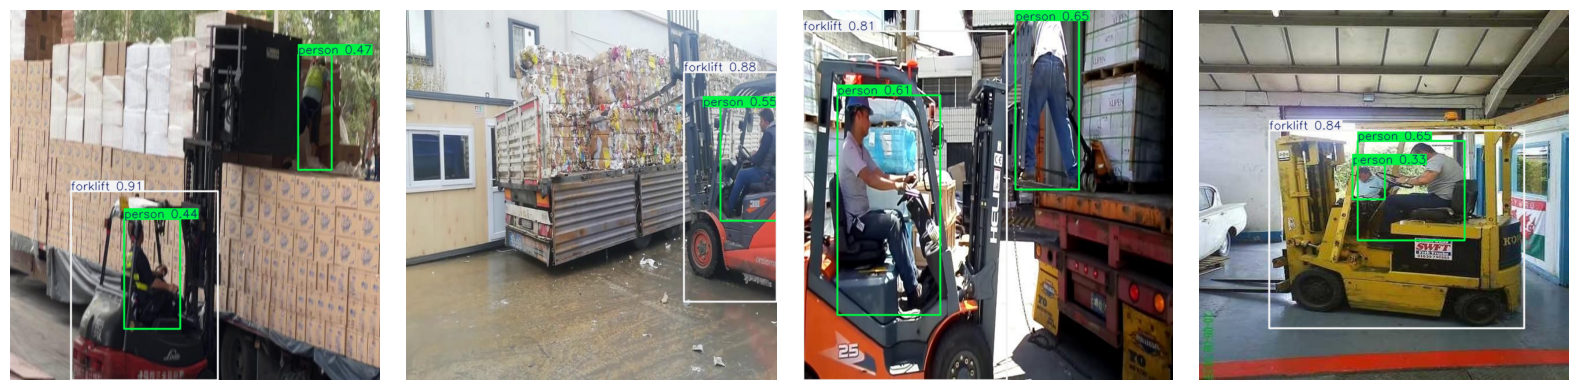

In [116]:
VAL_SHOW_N = 4
val_imgs = []
for ext in ("*.jpg", "*.jpeg", "*.png"):
    val_imgs.extend(glob.glob(os.path.join(val_dir, ext)))
val_imgs = val_imgs[:VAL_SHOW_N]

pred = model.predict(source=val_imgs, imgsz=IMGSZ, conf=0.25)
# Mostrar con matplotlib (usamos 'plot' de ultralytics para guardar)
out_dir = "runs/predict_display"
os.makedirs(out_dir, exist_ok=True)

fig, axes = plt.subplots(1, len(val_imgs), figsize=(4*len(val_imgs), 4))
if len(val_imgs) == 1:
    axes = [axes]
for ax, r in zip(axes, pred):
    im = r.plot()  # numpy array con anotaciones
    ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax.axis('off')
plt.tight_layout()
plt.show()

# 5. Export and deploy

In [13]:
!pip install -r requirements-test.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.3/252.3 kB 9.0 MB/s eta 0:00:00


In [11]:
pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 7.6 MB/s eta 0:00:00


In [12]:
pip install onnx onnxruntime

In [13]:

export_dir = Path("artifacts")
export_dir.mkdir(parents=True, exist_ok=True)

best_ckpt = None
for p in Path("runs/detect").rglob("weights/best.pt"):
    best_ckpt = p
    break

if best_ckpt and best_ckpt.exists():
    target = export_dir / "model_best.pt"
    target.write_bytes(best_ckpt.read_bytes())
    print("Wheight export to:", target)
else:
    print("'best.pt' not found")

with open(export_dir / "classes.json", "w") as f:
    json.dump({"nc": int(nc), "names": class_names}, f, indent=2)

try:
    _ = model.export(format="onnx", imgsz=IMGSZ)
    onnx_file = None
    for p in Path(".").rglob("*.onnx"):
        onnx_file = p
        break
    if onnx_file:
        (export_dir / "model.onnx").write_bytes(onnx_file.read_bytes())
        print("ONNX export to:", export_dir / "model.onnx")
except Exception as e:
    print("Export ONNX not available:", e)


Wheight export to: artifacts/model_best.pt
Ultralytics 8.3.74 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

PyTorch: starting from 'yolo11n.pt' with input shape (1, 3, 800, 800) BCHW and output shape(s) (1, 84, 13125) (5.4 MB)

ONNX: starting export with onnx 1.19.1 opset 9...


W1124 03:07:39.951000 4001 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 9 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/

Applied 1 of general pattern rewrite rules.
ONNX: slimming with onnxslim 0.1.75...
ONNX: export success ✅ 33.4s, saved as 'yolo11n.onnx' (10.2 MB)

Export complete (35.0s)
Results saved to /content/drive/MyDrive/Challenge_ML_Computer_Vision
Predict:         yolo predict task=detect model=yolo11n.onnx imgsz=800  
Validate:        yolo val task=detect model=yolo11n.onnx imgsz=800 data=/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml  
Visualize:       https://netron.app
ONNX export to: artifacts/model.onnx


# 6. TODOs (for the candidate)
- [ ] Analyze the class imbalance and propose strategies (weighting, augmented sampling, focal loss).
- [ ] Tune hyperparameters (epochs, image size, augmentations) to improve mAP.
- [ ] Record key metrics and justify the final baseline.
- [ ] Prepare all necessary artifacts in artifacts/ for the inference service (API).

# 7. Appendix — Notes on relative paths
- This notebook reads data.yaml and infers the paths to images/ and labels/ for train/, val/, and test/.
- If you move data.yaml to another folder, adjust DATA_YAML_PATH.
- If the dataset was downloaded from Roboflow, keep the standard YOLO folder structure.